### Enhanced LSTM for Natural Language Inference


### 一、模型组成：
ESIM模型总共有三层，Input Encoding、Local Inference Modeling以及Inference Composition.
这篇论文还涉及对parse-tree的处理，但ESIM模型是不包含对parse-tree的处理的。

#### 1.1、Input Encoding:encode the input premise and hypothesis 
一方面，对于序列数据，使用BiLSTM编码 local inference information and its interaction.
可以理解为在embedding层得到词向量之后，在当前的语境下重新编码，得到新的 embeding 向量。（来自知乎）
$$ \bar{a_{i}} = BiLSTM(a,i), $$ 
$$ \bar{b_{i}} = BiLSTM(b,i), $$ 



In [ ]:
#代码部分

#定义BiLSTM
self._encoding = nn.LSTM(self.embeds_dim, self.hidden_size, batch_first=True, bidirectional=True)

#batch_first为true：输入和输出Tensor的形状为(batch, seq_length, feature)

#其输出格式为 output, (h_n, c_n)
#output是最后的输出   output(seq_len, batch, hidden_size * num_directions)
#h_n为最后一个时间步的隐藏状态 h_n(num_layers * num_directions, batch, hidden_size)
#c_n为最后一个时间步的记忆细胞 c_n(num_layers * num_directions, batch, hidden_size)

#### 1.2 Local Inference Modeling：collect local inference for words and their context, and the  local information between (linguistic) phrases and clauses.

这一层引入了注意力机制

首先，计算attention weights：premise的第i个词  $\bar{a_{i}}$与hypothesis的第j个词 $\bar{b_{j}}$ 之间的相似度

$$ e_{ij} = \bar{a_{i}}^{T}\bar{b_{j}}$$

第二步，计算local inference

$$\tilde{a_{i}}= \sum_{j=1}^{l_{b}}\frac{exp(e_{ij})}{\sum_{k=1}^{l_{b}}exp(e_{ik})}\bar{b_{j}}$$
$$\tilde{b_{j}}= \sum_{i=1}^{l_{a}}\frac{exp(e_{ij})}{\sum_{k=1}^{l_{a}}exp(e_{ik})}\bar{a_{i}}$$

之后，再对提取的local inference进行enhancement，旨在sharpen local inference information between elements
and capture inference relationships such as contradiction

$$ m_{a} = [\bar{a},\tilde{a},\bar{a} - \tilde{a},\bar{a} \odot \tilde{a}] $$
$$ m_{b} = [\bar{b},\tilde{b},\bar{b} - \tilde{b},\bar{b} \odot \tilde{b}] $$


In [ ]:
#代码部分

def soft_attention_align(self, x1, x2, mask1, mask2):
    '''
    x1:premise的BiLSTM输出，batch_size * seq_len * hidden_dim
    x2:hypothesis的BiLSTM输出，batch_size * seq_len * hidden_dim
    '''
    attention = torch.matmul(x1, x2.transpose(1, 2))
    #attention: batch_size * seq_len * seq_len
    #transpose（1，2）表示第三维度和第二维度进行交换 （第一维度为0）
    #attention[,i,j]表示premise第i个词与hypothesis第j个词之间的相似度
    
    weight1 = F.softmax(attention, dim=-1)
    #weight1: batch_size * seq_len * seq_len
    x1_align = torch.matmul(weight1, x2)
    #x1_aligh: batch_size * seq_len * hidden_dim
    #x1_aligh对应local inference的ai
    
    weight2 = F.softmax(attention, dim=-1)
    #weight2: batch_size * seq_len * seq_len
    x2_align = torch.matmul(weight1, x1)
    #x2_aligh: batch_size * seq_len * hidden_dim
    return x1_align, x2_align

#下面这个函数对应于enhancement操作
def submul(self, x1, x2):
    mul = x1 * x2 #mul:batch_size * seq_len * hidden_dim
    sub = x1 - x2 #sub:batch_size * seq_len * hidden_dim
    return torch.cat([sub, mul], -1)
    #output:batch_size * seq_len * (2 * hidden_dim)

o1, _ = self._encoding(x1) #因为lstm的输出为output.(h_n,c_n)，计算attention只用到了output
o2, _ = self._encoding(x2)
q1_align = self.soft_attention_align(o1, o2, mask1, mask2)
q1_combined = torch.cat([o1, q1_align, self.submul(o1, q1_align)], -1) #这个就是上述公式对应的ma 

In [5]:
import numpy as np
import random
attention = np.random.randn(2,3,3)
print(attention) #该batch大小为2，第一个样本计算得到的attention是a[0,:,:],第二个样本是a[1,:,:]
#每个batch为(seq_length,seq_dimention)
attention[0,1,2]  #表示根据第一个样本计算得到，premise中第二个词与hypothesis中第三个词的相似度


[[[-0.25918461  0.0251016   1.87939035]
  [-0.71518417  0.78767044 -0.54382419]
  [-2.04184281 -0.98905344  0.24922853]]

 [[-0.53825093 -0.46995352  0.89274492]
  [-0.41132193  0.42398133  0.10643665]
  [ 0.37872922 -1.04112709 -0.52354053]]]


-0.5438241852884557

#### 1.3 Inference Composition
这一层对于序列数据的处理依然使用了BiLSTM进行decoder处理，因为在上一层的$ m_{a}和 m_{b}$引入了大量的参数，提高了过拟合的几率，因此不会直接将$ m_{a}以及 m_{b}$作为decoder输入，要先让它们都经过一层前馈神经网络，其激活函数为ReLu，经过神经网络后,再进入BiLSTM.
之后对于BiLSTM输出的premise和hypothesis分别求其average_pooling和max_pooling,然后将得到的四个向量合并，得到最终的输出向量v，如下图所示
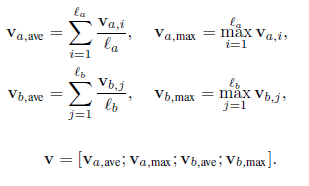

之后让v通过一个多层感知机（激活函数为tanh），再通过softmax后得到最终结果。

In [ ]:
#定义一层前馈神经网络，因为此时ma和mb的维度是原始隐藏层的四倍
self._projection = nn.Sequential(nn.Linear(4*self.hidden_dim,
                                                   self.hidden_dim),
                                         nn.ReLU())
#output：batch_size * hidden_dim * hidden_dim

#使用BiLSTM进行decoder
self._composition = nn.LSTM(self.hidden_dim, self.hidden_dim, batch_first=True, bidirectional=True)

#池化层
def apply_multiple(self, x):
    # input: batch_size * seq_len * (2 * hidden_dim)
    p1 = F.avg_pool1d(x.transpose(1, 2), x.size(1)).squeeze(-1)
    p2 = F.max_pool1d(x.transpose(1, 2), x.size(1)).squeeze(-1)
    # output: batch_size * (4 * hidden_size)
    return torch.cat([p1, p2], 1)

#多层感知机和softmax
self._classification = nn.Sequential(nn.Dropout(p=self.dropout),
                                     nn.Linear(2*4*self.hidden_size,
                                               self.hidden_size),
                                     nn.Tanh(),
                                     nn.Dropout(p=self.dropout),
                                     nn.Linear(self.hidden_size,
                                               self.num_classes))

### 二、超参数设置

Adam：The first momentum is set to be 0.9 and the second 0.999. The initial learning rate is 0.0004

batch size:32

hidden_states:300

dropout：0.5

OOV：initialized randomly with Gaussian samples.

pre-trained embedding:300-D Glove 840B vectors

### 三、感想总结

#### 3.1 论文阅读
看这篇论文的背景知识是只了解前馈神经网络、循环神经网络、seq2seq模型以及attention，而第一次看这篇论文时不太理解这个模型，简直云里雾里，对natural language inference也不了解。后来去google了natural language inference的一些介绍，再多看几遍论文之后，发现实质上是一个使用attention机制的seq2seq模型，因为输入数据不仅是原始的文本序列数据，还根据原始的文本数据建立了语法树也作为输入，因此模型有左右两边，左边是对序列数据处理，右边是对语法树进行处理。不过ESIM模型是只包含对序列数据的处理。

ESIM模型的encoder和decoder都使用了BiLSTM，对premise和hypothesis并行处理，在最后一层全连接层之前，把两者产生的向量concatate起来，传入全连接层进行预测。


#### 3.2 模型代码
代码的难点对我来说在于各种张量维度之间的计算，刚开始直接看动手学深度学习成套的代码，有点云里雾里，归根结底还是张量之间的计算维度还没搞懂，之后顺了一下，感觉好多了：

1、手写一遍公式，了解张量维度的相乘，比如$\boldsymbol{X}_t \in \mathbb{R}^{n \times d}$是时间步$t$的小批量输入，$\boldsymbol{H}_t  \in \mathbb{R}^{n \times h}$然后输出$$
\boldsymbol{H}_t = \phi(\boldsymbol{X}_t \boldsymbol{W}_{xh} + \boldsymbol{H}_{t-1} \boldsymbol{W}_{hh}  + \boldsymbol{b}_h).
$$

2、对照着公式，多敲几次代码,用torch.randn生成几个随机数矩阵，放入计算代码中，一步步运算查看结果，标注输入和输出的维度

3、去Pytorch官方文档里看对应模型的输出参数，以及模型会输出什么和输出的维度

### 四、参考资料

Chen, Q., Zhu, X., Ling, Z., Wei, S., Jiang, H., & Inkpen, D. (2016). Enhanced LSTM for Natural Language Inference

PyTorch documentation